In [222]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
import torch.nn.functional as F


In [223]:
network_config = {}
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [224]:
# implement a basic tokenizer from scratch (Anderj Karpathy's tutorial)
class BasicTokenizer:
    def __init__(self, vocab_size=300):
        self.vocab = {}
        self.merges = {}
        self.vocab_size = vocab_size
        # self.ids = []
    def train(self, text, verbose=False):
        tokens = self.read_file(text)
        num_merge = self.vocab_size - 256
        ids = tokens.copy()
        for i in range(num_merge):
            num_merge = 256 + i
            stats = self.get_stats(ids)
            top_pair = self.get_top_pair(stats)
            if verbose:
                print(f"merging {top_pair} into {num_merge}")
            ids = self.merge(ids, top_pair, num_merge)
            self.merges[top_pair] = num_merge
        self.vocab = {idx: bytes([idx]) for idx in range(256)}
        for (p1, p2), idx in self.merges.items():
            self.vocab[idx] = self.vocab[p1] + self.vocab[p2]
        # self.ids = ids
        return ids
    
    def read_file(self, text):
        tokens = text.encode("utf-8")
        tokens = list(map(int, tokens))
        return tokens
    def get_stats(self, tokens):
        maps = {}
        for p1, p2 in zip(tokens, tokens[1:]):
            maps[(p1, p2)] = maps.get((p1, p2), 0) + 1
        return maps
    def get_top_pair(self, maps):
        top_pair = max(maps, key=maps.get)
        # self.merges.append(top_pair)
        return top_pair
    def merge(self, ids, top_pair, idx):
        res = []
        i = 0
        p1, p2 = top_pair
        while i < len(ids):
            if i < len(ids) - 1 and ids[i] == p1 and ids[i+1] == p2:
                self.merges[top_pair] = idx
                res.append(idx)
                i += 2
            else:
                res.append(ids[i])
                i += 1
        return res
    def encode(self, text):
        tokens = self.read_file(text)
        ids = tokens.copy()
        i = 0
        res = []
        while i < len(ids):
            if i < len(ids) - 1 and (ids[i], ids[i+1]) in self.merges:
                res.append(self.merges[(ids[i], ids[i+1])])
                i+=2
            else:
                res.append(ids[i])
                i+=1
        return res
    def decode(self, ids):
        bytes_string = b"".join(self.vocab[idx] for idx in ids)
        return bytes_string.decode("utf-8", errors="replace")
    

In [225]:
tokenizer = BasicTokenizer()
text = open("./data/random_book.txt", "r", encoding="utf-8").read()
tokenizer.train(text)
tokens = tokenizer.encode(text)
print(tokens)
print(tokenizer.decode(tokens) == text)

[84, 104, 256, 80, 114, 111, 106, 101, 99, 259, 71, 117, 116, 272, 98, 263, 103, 32, 101, 66, 111, 111, 107, 32, 111, 283, 84, 104, 256, 99, 298, 264, 103, 32, 111, 283, 112, 284, 99, 101, 10, 260, 260, 10, 84, 289, 258, 101, 98, 111, 111, 107, 32, 105, 258, 102, 276, 32, 257, 256, 117, 297, 32, 111, 283, 268, 121, 271, 256, 268, 121, 119, 104, 263, 256, 264, 32, 257, 256, 85, 110, 293, 101, 267, 83, 116, 299, 290, 32, 268, 100, 10, 109, 111, 285, 32, 111, 257, 263, 32, 112, 295, 116, 258, 111, 283, 257, 256, 119, 276, 108, 267, 299, 32, 110, 274, 99, 111, 285, 32, 268, 267, 119, 293, 104, 32, 97, 108, 109, 111, 285, 32, 110, 274, 114, 290, 116, 114, 105, 99, 116, 105, 271, 115, 10, 119, 277, 116, 115, 111, 101, 118, 263, 286, 89, 265, 32, 109, 97, 273, 99, 111, 112, 273, 293, 266, 103, 105, 118, 256, 293, 32, 97, 119, 97, 273, 276, 32, 114, 101, 45, 117, 297, 32, 293, 32, 117, 110, 100, 263, 32, 257, 256, 116, 263, 109, 115, 10, 111, 283, 257, 256, 80, 114, 111, 106, 101, 99, 259, 71,

In [226]:
dataset = torch.tensor(tokens, dtype=torch.long).to(device)
print(dataset.shape, dataset.dtype)

print(dataset)

torch.Size([108524]) torch.int64
tensor([ 84, 104, 256,  ..., 115,  46, 262], device='cuda:0')


In [227]:
def get_batch(dataset, batch_size, context_window, split="train"):
    train_data = dataset[:int(len(dataset)*0.8)]
    val_data = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
    test_data = dataset[int(len(dataset)*0.9):]

    # batch_data = train_data
    if split == "train":
        batch_data = train_data
    elif split == "val":
        batch_data = val_data
    elif split == "test":
        batch_data = test_data
    ix = torch.randint(0, len(batch_data)-context_window, (batch_size, ))
    x = torch.stack([batch_data[i:i+context_window] for i in ix])
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

In [228]:
network_config.update({
    'batch_size': 16,
    'context_window': 16,
})


In [229]:
xs, ys = get_batch(dataset, **network_config)
test_data = [(tokenizer.decode(xs[i].tolist()), tokenizer.decode(ys[i].tolist())) for i in range(len(xs))]
print(test_data)


[('rateful for—but Wi', 'ateful for—but Will'), ('And then\nI—literally�', 'nd then\nI—literally—'), ('k him, he will make it', ' him, he will make it '), ('under Robert’s eyes', 'nder Robert’s eyes_'), ('y, and that spares peop', ', and that spares peopl'), ('usta is so nervous—j', 'sta is so nervous—ju'), ('iced that the\nbusiness ', 'ced that the\nbusiness w'), ('e, mother.\n\nMRS SCHO', ', mother.\n\nMRS SCHOL'), (' such a man?\n\n  [_E', 'such a man?\n\n  [_En'), ('d\nphilosophy.\n\nWIL', '\nphilosophy.\n\nWILL'), ('support against the wa', 'upport against the wall'), ('ut increasing sarcasm', 't increasing sarcasm, '), ('admire. With my\ncu', 'dmire. With my\ncur'), ('    fur cap and muff', '  fur cap and muff. '), (' so\nthat I could come d', 'so\nthat I could come dow'), ('moments of excitement d', 'oments of excitement de')]


In [230]:
def get_loss(model, network_config):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            x, y = get_batch(dataset, **network_config, split=split)
            _, loss = model(x, y)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

In [231]:
class MLP(nn.Module):
    def __init__(self, network_config, vocab_size, embed_dim):
        super().__init__()
        self.network_config = network_config
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embed_dim)
        self.linear1 = nn.Linear(self.embed_dim, self.embed_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(self.embed_dim, self.vocab_size)
        print(f"#params: {sum(p.numel() for p in self.parameters())}")

    def forward(self, x, target=None):
        B, T = x.shape
        x = self.embedding(x)
        x = self.linear1(x)
        x = self.relu(x)
        logits = self.linear2(x)
        if target is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), target.view(-1))
            return logits, loss
        return logits


In [232]:
model = MLP(network_config, tokenizer.vocab_size, 128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#params: 93612


In [233]:
def train(model, optimizer, network_config, epoch=100, verbose=False):
    losses = []
    val_losses = []
    start = time.time()
    for i in range(epoch):
        x, y = get_batch(dataset, **network_config)
        out, loss = model(x, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # losses.append(loss.item())
        # if verbose:
        if i % 100 == 0:
            losses.append(loss.item())
            with torch.no_grad():
                x_val, y_val = get_batch(dataset, **network_config, split="val")
                out_val, loss_val = model(x_val, y_val)
                val_losses.append(loss_val.item())
                if verbose:
                    print(f"epoch {i} loss: {loss.item()}")
                    print(f"val loss: {loss_val.item()}")

    print(f"train time: {time.time() - start}")
    print(f"train loss: {np.mean(loss.item())}")
    return losses, val_losses




In [234]:
train_loss, val_losses = train(model, optimizer, network_config, epoch=10000, verbose=False)




train time: 31.348471641540527
train loss: 2.9392731189727783


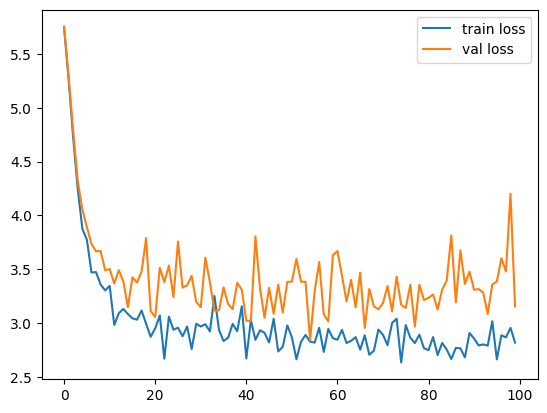

In [235]:
plt.plot(train_loss, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend()
plt.show()

In [236]:
def generate(model, network_config, tokenizer, context_window=16, max_tokens=100):
    model.eval()
    idx = torch.zeros((1, context_window), dtype=torch.long).to(device)
    for _ in range(max_tokens):
        out = model(idx)
        out = out[:, -1, :]
        probs = torch.softmax(out, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=-1)
    return tokenizer.decode(idx.squeeze().tolist())

print(generate(model, network_config, tokenizer))

                 and to er. Weey—“ing it!’t yousom_).—ys bedenshere fwas aing HOBs h nis, Farchene
burneralf I kinto ht you—T.

IAuries m. NE


RMSNoem part

In [237]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps, partial=-1):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(dim))
        self.eps = eps
        self.partial = partial

    def forward(self, x):
        origin_shape = x.shape
        x = x.view(-1, x.shape[-1])
        if 1 >= self.partial > 0:
            partial_size = int(self.partial * x.shape[-1])
            mask = torch.rand(x.shape[-1]) < self.partial # random select index
            x_partial = x[:, mask] # select partial index
            rms = torch.sqrt(x_partial.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        else:
            rms = torch.sqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        
        x_normalized = x / rms
        x_scaled = x_normalized * self.scale
        return x_scaled.view(origin_shape)


In [238]:
class MLP_rms(nn.Module):
    def __init__(self, network_config, vocab_size, embed_dim):
        super().__init__()
        self.network_config = network_config
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embed_dim)
        self.rms = RMSNorm(self.embed_dim, eps=1e-5)
        self.linear = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_dim),
            nn.ReLU(),
            nn.Linear(self.embed_dim, self.vocab_size)
        )
        print(f"#params: {sum(p.numel() for p in self.parameters())}")

    def forward(self, x, target=None):
        x = self.embedding(x)
        x = self.rms(x)
        logits = self.linear(x)
        if target is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, logits.shape[-1]), target.view(-1))
            return logits, loss
        return logits


In [239]:
model = MLP_rms(network_config, tokenizer.vocab_size, 128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_loss, val_loss = train(model, optimizer, network_config, epoch=10000, verbose=False)

#params: 93740
train time: 47.326342821121216
train loss: 2.8428378105163574


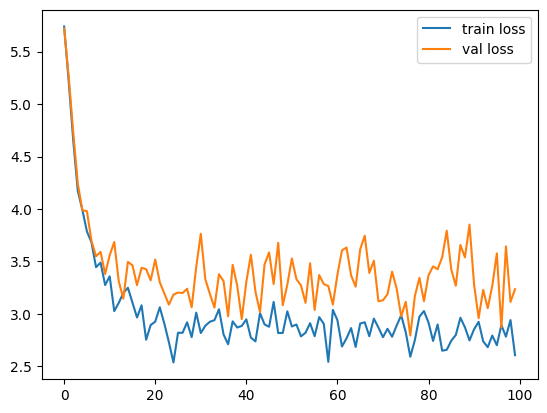

In [240]:
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()
plt.show()


RoPE part

In [241]:
class RoPE(nn.Module):
    def __init__(self, dim, base=10000):
        super().__init__()
        self.dim = dim
        self.base = base
        inv_freq = 1.0 / (base**(torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)

    def _rotate_half(self, x):
        x1, x2 = x[..., :self.dim//2], x[..., self.dim//2:]
        return torch.cat((-x2, x1), dim=-1)
    def forward(self, x, seq_len=None):
        """
        x: [batch_size, num_heads, seq_len, dim]
        """
        if seq_len is None:
            seq_len = x.shape[-2]
        t = torch.arange(seq_len, device=x.device).type_as(self.inv_freq)
        freqs = torch.einsum('i, j->ij', t, self.inv_freq)
        freqs = freqs.unsqueeze(0).unsqueeze(0)  # [1, 1, seq_len, dim/2]
        freqs = freqs.expand(x.shape[0], x.shape[1], -1, -1)
        theta = torch.cat((freqs, freqs), dim=-1)
        cos = theta.cos()
        sin = theta.sin()
        return x*cos + self._rotate_half(x) * sin


In [242]:
rope = RoPE(128, base=1000).to(device)
x = torch.randn(1, 8, 16, 128).to(device)
x_rot = rope(x)
print(x_rot.shape)

torch.Size([1, 8, 16, 128])


In [243]:
import math
class RoPeMultiHeadAttention(nn.Module):
    def __init__(self, network_config, embed_dim, num_heads):
        super().__init__()
        self.network_config = network_config
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim
        self.wq = nn.Linear(embed_dim, embed_dim)
        self.wk = nn.Linear(embed_dim, embed_dim)
        self.wv = nn.Linear(embed_dim, embed_dim)
        self.wo = nn.Linear(embed_dim, embed_dim)
        self.rope = RoPE(self.head_dim, base=10000)

    def get_causal_mask(self, seq_len, device):
        mask = torch.ones((seq_len, seq_len), device=device).tril()
        mask = mask.log()
        return mask
        
    def forward(self, x):
        B, T, C = x.shape
        
        # 线性变换并分头
        q = self.wq(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.wk(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.wv(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        
        # 应用RoPE编码
        q = self.rope(q)
        k = self.rope(k)
        
        # 计算注意力分数
        scale = 1.0 / math.sqrt(self.head_dim)
        attn = torch.matmul(q, k.transpose(-2, -1)) * scale  # [B, nh, T, T]
        
        # 应用因果掩码
        causal_mask = self.get_causal_mask(T, x.device)
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)  # [1, 1, T, T]
        
        # 将掩码加到注意力分数上（不使用masked_fill）
        attn = attn + causal_mask
        
        # 应用softmax
        attn = F.softmax(attn, dim=-1)
        
        # 计算输出
        out = torch.matmul(attn, v)  # [B, nh, T, T] x [B, nh, T, hd] -> [B, nh, T, hd]
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.wo(out)
        
        return out


In [244]:
class RopeModel(nn.Module):
    def __init__(self, network_config, vocab_size, embed_dim, num_heads):
        super().__init__()
        self.network_config = network_config
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.mha = RoPeMultiHeadAttention(network_config, embed_dim, num_heads)
        self.rms1 = RMSNorm(embed_dim, eps=1e-5)
        self.rms2 = RMSNorm(embed_dim, eps=1e-5)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU()
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size)
        print(f"#params: {sum(p.numel() for p in self.parameters())}")
    def forward(self, x, target=None):
        x = self.embedding(x)
        x = self.rms1(x)
        x = x + self.mha(x)
        x = self.rms2(x)
        x = x + self.linear(x)
        logits = self.lm_head(x)
        if target is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), target.view(-1))
            return logits, loss
        return logits


#params: 159916
epoch 0 loss: 5.8225836753845215
val loss: 5.883604526519775


epoch 100 loss: 5.189703941345215
val loss: 5.311426162719727
epoch 200 loss: 4.213424205780029
val loss: 4.288457870483398
epoch 300 loss: 3.6353700160980225
val loss: 3.984715700149536
epoch 400 loss: 3.4185471534729004
val loss: 3.6493546962738037
epoch 500 loss: 3.4772932529449463
val loss: 3.743664264678955
epoch 600 loss: 3.0373036861419678
val loss: 3.588939666748047
epoch 700 loss: 3.213014602661133
val loss: 3.507593870162964
epoch 800 loss: 3.1037938594818115
val loss: 3.406524181365967
epoch 900 loss: 3.2198116779327393
val loss: 3.502760171890259
epoch 1000 loss: 2.9416086673736572
val loss: 3.408632278442383
epoch 1100 loss: 3.105367660522461
val loss: 3.1330296993255615
epoch 1200 loss: 3.124796152114868
val loss: 3.249736785888672
epoch 1300 loss: 2.659644842147827
val loss: 3.3465466499328613
epoch 1400 loss: 2.9910919666290283
val loss: 3.2352373600006104
epoch 1500 loss: 2.7938392162323
val loss: 3.175471305847168
epoch 1600 loss: 2.7611875534057617
val loss: 3.640068

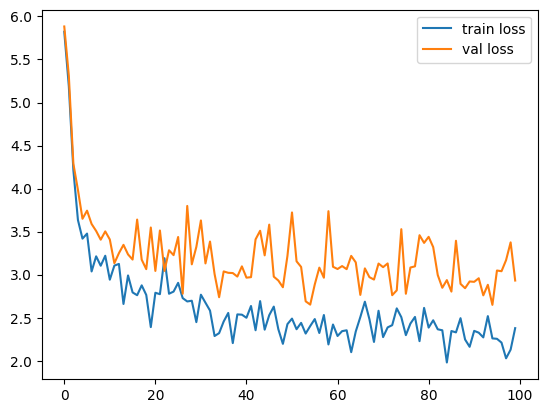

In [245]:
model = RopeModel(network_config, tokenizer.vocab_size, 128, 8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_loss, val_loss = train(model, optimizer, network_config, epoch=10000, verbose=True)
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()
plt.show()


SwiGLU Part

In [246]:
class SwiGLU(nn.Module):
    def __init__(self, in_features, hidden_features):
        super().__init__()
        hidden_features = hidden_features or in_features * 2
        self.w1 = nn.Linear(in_features, hidden_features)
        self.w2 = nn.Linear(in_features, hidden_features)
        self.proj = nn.Linear(hidden_features, in_features)

    def forward(self, x):
        gate = self.w1(x)
        value = self.w2(x)
        gate_activated = F.silu(gate)
        gate_value = gate_activated * value
        return self.proj(gate_value)


In [247]:
class RopeModel(nn.Module):
    def __init__(self, network_config, vocab_size, embed_dim, num_heads):
        super().__init__()
        self.network_config = network_config
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.mha = RoPeMultiHeadAttention(network_config, embed_dim, num_heads)
        self.rms1 = RMSNorm(embed_dim, eps=1e-5)
        self.rms2 = RMSNorm(embed_dim, eps=1e-5)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            SwiGLU(embed_dim, embed_dim * 4) # change relu to swiglu
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size)
        print(f"#params: {sum(p.numel() for p in self.parameters())}")
    def forward(self, x, target=None):
        x = self.embedding(x)
        x = self.rms1(x)
        x = x + self.mha(x)
        x = self.rms2(x)
        x = x + self.linear(x)
        logits = self.lm_head(x)
        if target is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), target.view(-1))
            return logits, loss
        return logits


#params: 357676
epoch 0 loss: 5.898924827575684
val loss: 5.905057430267334
epoch 100 loss: 5.075182914733887
val loss: 5.1513166427612305
epoch 200 loss: 3.6976985931396484
val loss: 3.9246411323547363
epoch 300 loss: 3.421535015106201
val loss: 3.58607816696167
epoch 400 loss: 3.0508947372436523
val loss: 3.598111152648926
epoch 500 loss: 3.0278830528259277
val loss: 3.236191987991333
epoch 600 loss: 3.015854597091675
val loss: 3.1545517444610596
epoch 700 loss: 2.83059024810791
val loss: 3.286761999130249
epoch 800 loss: 2.5920937061309814
val loss: 3.0166029930114746
epoch 900 loss: 2.8358166217803955
val loss: 3.166966438293457
epoch 1000 loss: 2.727436065673828
val loss: 3.2727527618408203
epoch 1100 loss: 2.6590161323547363
val loss: 3.3493776321411133
epoch 1200 loss: 2.7632429599761963
val loss: 2.983335018157959
epoch 1300 loss: 2.8070716857910156
val loss: 3.058638334274292
epoch 1400 loss: 2.956568717956543
val loss: 3.5417909622192383
epoch 1500 loss: 2.4395923614501953
va

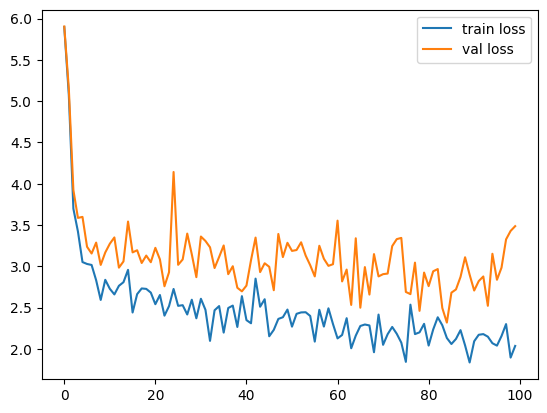

In [248]:
model = RopeModel(network_config, tokenizer.vocab_size, 128, 8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_loss, val_loss = train(model, optimizer, network_config, epoch=10000, verbose=True)
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()
plt.show()


In [249]:
class LlamaBlock(nn.Module):
    def __init__(self, network_config, embed_dim, num_heads):
        super().__init__()
        self.network_config = network_config
        self.rms1 = RMSNorm(embed_dim, eps=1e-5)
        self.mha = RoPeMultiHeadAttention(network_config, embed_dim, num_heads)
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            SwiGLU(embed_dim*2, embed_dim * 4),
            nn.Linear(embed_dim * 2, embed_dim)
        )
        self.rms2 = RMSNorm(embed_dim, eps=1e-5)
        print(f"#params: {sum(p.numel() for p in self.parameters())}")
    def forward(self, x):
        x = self.rms1(x)
        x = x + self.mha(x)
        x = self.rms2(x)
        x = x + self.feedforward(x)
        return x


In [250]:
# test model
block = LlamaBlock(network_config, 128, 8).to(device)
x = torch.randn(1, 16, 128).to(device)
out = block(x)
print(out.shape)


#params: 526720
torch.Size([1, 16, 128])


In [251]:
from collections import OrderedDict
class Llama(nn.Module):
    def __init__(self, network_config, vocab_size, embed_dim, num_heads, num_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.llama_blocks = nn.Sequential(
            OrderedDict([
                (f"llama_{i}", LlamaBlock(network_config, embed_dim, num_heads)) for i in range(num_layers)])
        )
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            SwiGLU(embed_dim, embed_dim * 4),
            nn.Linear(embed_dim, embed_dim)
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size)
        print(f"#params: {sum(p.numel() for p in self.parameters())}")
    def forward(self, x, target=None):
        x = self.embeddings(x)
        x = self.llama_blocks(x)
        x = self.ffn(x)
        logits = self.lm_head(x)
        if target is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), target.view(-1))
            return logits, loss
        return logits


In [252]:
llama = Llama(network_config, tokenizer.vocab_size, 128, 8, 8).to(device)

#params: 526720
#params: 526720
#params: 526720
#params: 526720
#params: 526720
#params: 526720
#params: 526720
#params: 526720
#params: 4521644


epoch 0 loss: 5.701200485229492
val loss: 5.708914756774902


epoch 100 loss: 5.686168670654297
val loss: 5.679950714111328
epoch 200 loss: 5.410778999328613
val loss: 5.408322334289551
epoch 300 loss: 4.397401332855225
val loss: 4.7271199226379395
epoch 400 loss: 4.2632575035095215
val loss: 4.503233432769775
epoch 500 loss: 4.277907371520996
val loss: 4.210705280303955
epoch 600 loss: 3.7614493370056152
val loss: 4.015998840332031
epoch 700 loss: 3.8014626502990723
val loss: 4.033496379852295
epoch 800 loss: 3.6706621646881104
val loss: 3.8445723056793213
epoch 900 loss: 3.671827554702759
val loss: 3.804596424102783
epoch 1000 loss: 3.679058074951172
val loss: 3.68422269821167
epoch 1100 loss: 3.406324625015259
val loss: 3.699472427368164
epoch 1200 loss: 3.319335699081421
val loss: 3.8318545818328857
epoch 1300 loss: 3.397737741470337
val loss: 3.7272756099700928
epoch 1400 loss: 3.484365224838257
val loss: 3.710505962371826
epoch 1500 loss: 3.2257540225982666
val loss: 3.5425119400024414
epoch 1600 loss: 3.4927406311035156
val loss: 3.9890275

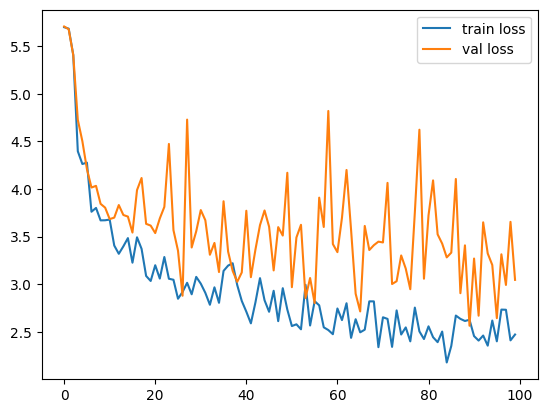

In [253]:
optimizer = torch.optim.Adam(llama.parameters(), lr=1e-5)
train_loss, val_loss = train(llama, optimizer, network_config, epoch=10000, verbose=True)
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()
plt.show()

In [254]:
print(generate(llama, network_config, tokenizer))

                Mt lig for a goof t! had you to Saver ta—thent—A.

Asive stiligher I wmd acom!

  [_RIt in tof and to way.

Mre cace youre ly I ta


In [255]:
xs, ys = get_batch(dataset, **network_config, split="test")
logits, loss = llama(xs, ys)
print(loss)

tensor(5.0563, device='cuda:0', grad_fn=<NllLossBackward0>)
